In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.cluster import hierarchy
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold

import custom_map

In [41]:
import importlib

importlib.reload(custom_map)

<module 'custom_map' from '/Users/dominikmika/PycharmProjects/Ridge-Hill-Climbing/src/custom_map.py'>

# Data preprocessing

In [64]:
data = pd.read_csv("../dataset/train.csv")

data.drop('id', axis=1, inplace=True)

target = "Heart Disease"
data['Heart Disease'] = np.where(data['Heart Disease'] == 'Presence', 1, 0)

binary_cols = data.columns[data.nunique() == 2]

categorical_cols = data.columns[(data.nunique() <= 10) & (data.nunique() > 2)]

data.nunique()

numerical_cols = list(set(data.columns).difference(binary_cols, categorical_cols))

numerical_features = pd.concat([data[numerical_cols], data[target]], axis=1).drop(columns = [target])
binary_features = data[binary_cols].drop(columns = [target])
categorical_binary_features = pd.concat([data[categorical_cols], data[binary_cols]], axis=1).drop(columns = [target])
categorical_features = pd.concat([data[categorical_cols], data[target]], axis=1).drop(columns = [target])
numerical_binary_features = pd.concat([data[numerical_cols], data[binary_cols]], axis=1).drop(columns = [target])

categorical_encoded = pd.get_dummies(categorical_features, columns=categorical_cols, drop_first=True, dtype=float)
categorical_encoded_binary_features = pd.concat([categorical_encoded, binary_features], axis=1)
data_encoded = pd.concat([categorical_encoded, binary_features, numerical_features], axis=1)
data_encoded

,Chest pain type_2,Chest pain type_3,Chest pain type_4,EKG results_1,EKG results_2,Slope of ST_2,Slope of ST_3,Number of vessels fluro_1,Number of vessels fluro_2,Number of vessels fluro_3,Thallium_6,Thallium_7,Sex,FBS over 120,Exercise angina,Cholesterol,ST depression,Age,Max HR,BP
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0,1,239,3.6,58,158,152
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,325,0.0,52,171,125
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,188,0.0,56,151,160
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,229,1.0,44,150,134
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1,234,3.8,58,125,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,226,0.0,56,132,110
629996,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,249,0.0,54,150,128
629997,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0,0,275,0.0,67,149,130
629998,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,199,0.0,52,157,140


# Mutual Information


In [43]:
mi_scores = mutual_info_classif(data_encoded, data[target])

mi_df = pd.DataFrame({
    "Feature": data_encoded.columns,
    "Mutual Information": mi_scores
}).sort_values("Mutual Information", ascending=False)

print(mi_df)

                      Feature  Mutual Information
11                 Thallium_7            0.230801
2           Chest pain type_4            0.208825
12                        Sex            0.132272
18                     Max HR            0.128730
5               Slope of ST_2            0.124574
14            Exercise angina            0.123312
16              ST depression            0.107683
1           Chest pain type_3            0.093644
4               EKG results_2            0.075384
8   Number of vessels fluro_2            0.045467
7   Number of vessels fluro_1            0.040236
17                        Age            0.029658
0           Chest pain type_2            0.029295
9   Number of vessels fluro_3            0.017481
15                Cholesterol            0.011383
19                         BP            0.010165
6               Slope of ST_3            0.003709
13               FBS over 120            0.002426
10                 Thallium_6            0.002279


# Chi-squared

In [44]:
chi_scores, p_values = chi2(categorical_encoded_binary_features, y)

chi_df = pd.DataFrame({
    "Feature": categorical_encoded_binary_features.columns,
    "Chi2": chi_scores,
    "p_value": p_values
}).sort_values("Chi2", ascending=False)

print(chi_df)

                      Feature           Chi2        p_value
11                 Thallium_7  134408.689393   0.000000e+00
14            Exercise angina   89334.275314   0.000000e+00
2           Chest pain type_4   82610.087071   0.000000e+00
5               Slope of ST_2   61536.783100   0.000000e+00
1           Chest pain type_3   52959.441857   0.000000e+00
8   Number of vessels fluro_2   44210.991955   0.000000e+00
7   Number of vessels fluro_1   34154.536720   0.000000e+00
0           Chest pain type_2   24811.594245   0.000000e+00
12                        Sex   21075.312014   0.000000e+00
9   Number of vessels fluro_3   18814.693084   0.000000e+00
4               EKG results_2   15432.382295   0.000000e+00
6               Slope of ST_3    4659.433675   0.000000e+00
10                 Thallium_6    2512.595464   0.000000e+00
13               FBS over 120     653.197059  4.506262e-144
3               EKG results_1      41.655178   1.088767e-10


# Correlation

{'name': 'g-bajon', 'alpha_eff': 0.0035714285714285718, 'df': 629998.0, 't_crit': 2.913737290900642, 'r_crit': 0.003670945024303667, 'steps': 2, 'side_left': 127, 'side_right': 127, 'N': 630000.0}


/Users/dominikmika/PycharmProjects/Ridge-Hill-Climbing/src/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


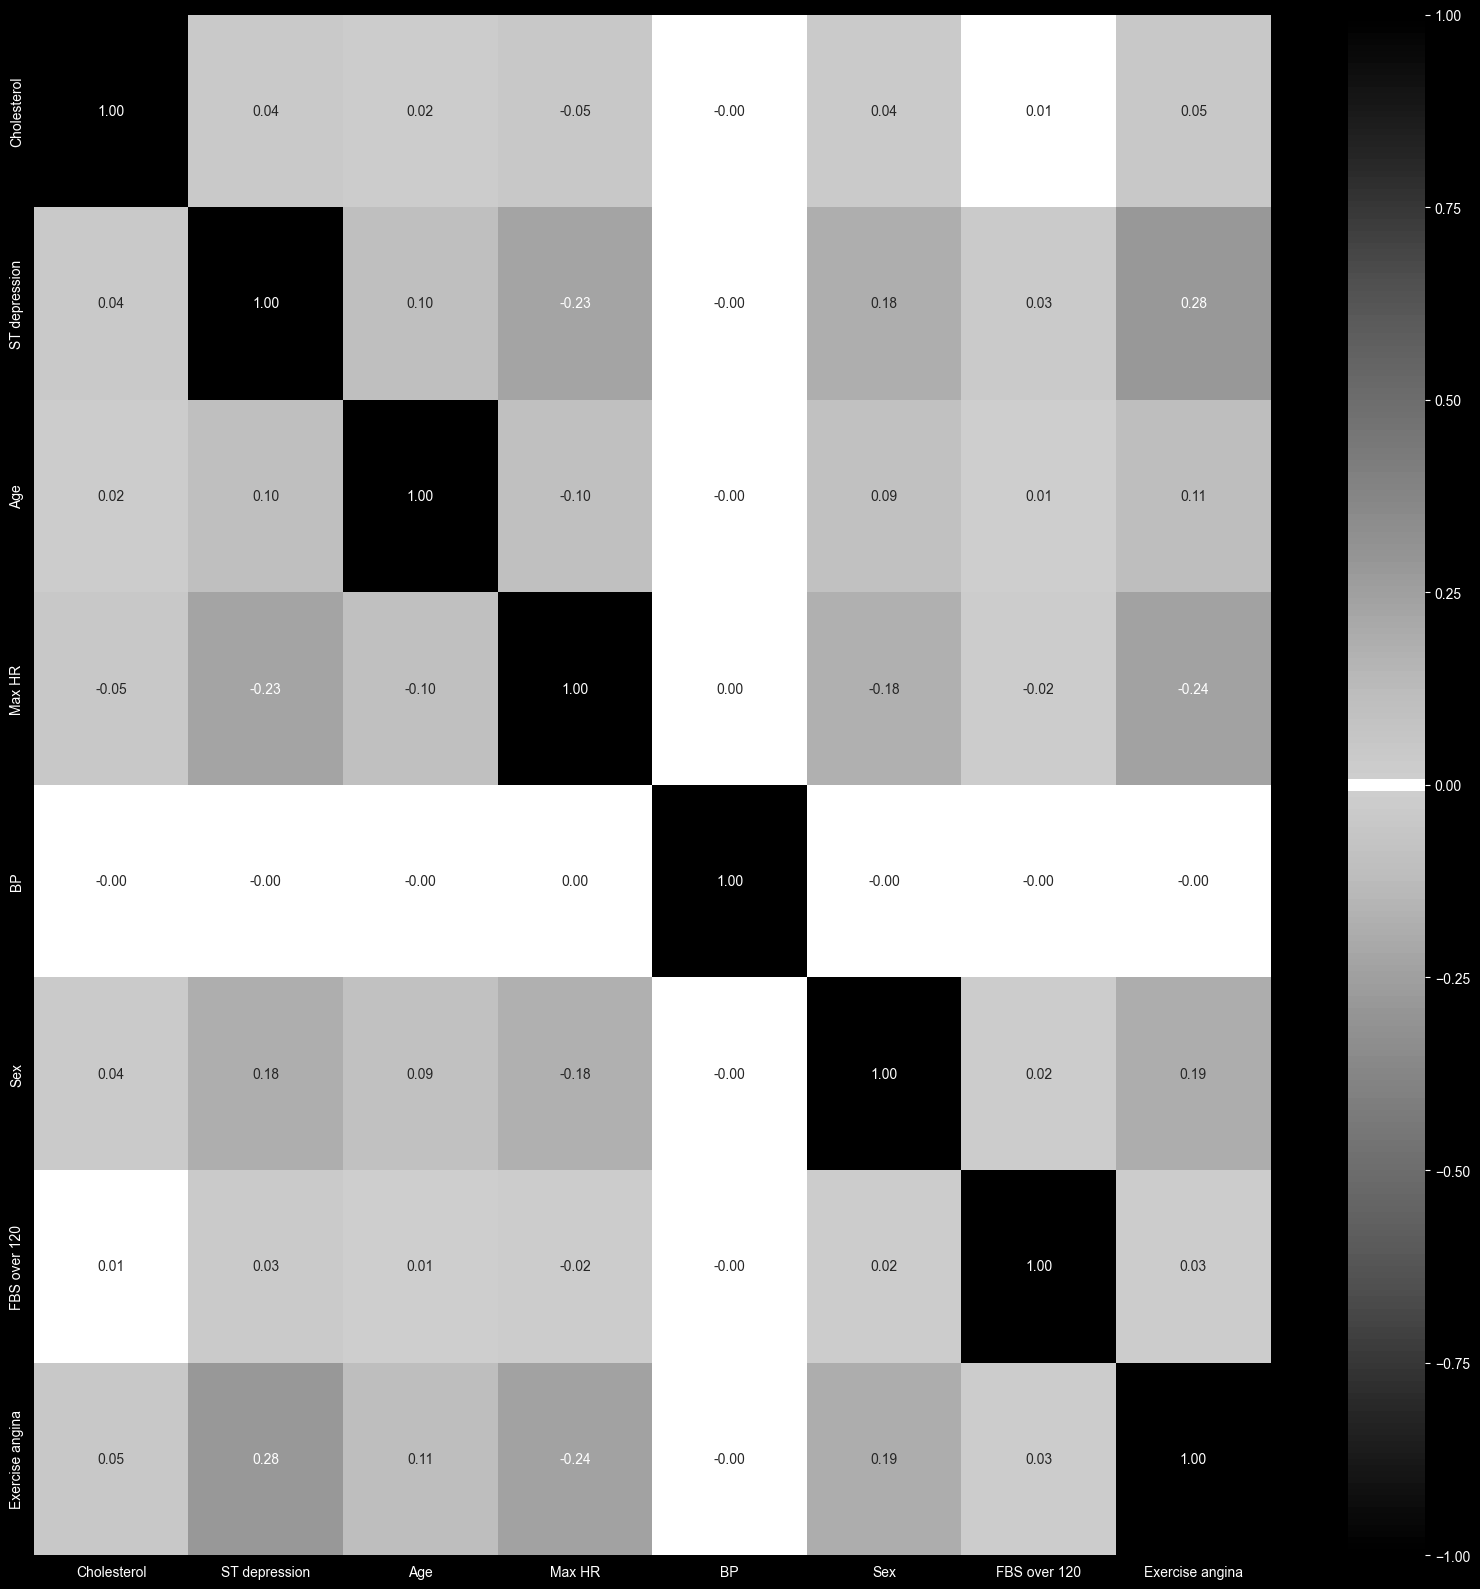

In [45]:
feature_list = numerical_binary_features

correlation_data = feature_list.corr()

n_features = feature_list.shape[1]
n = feature_list.size/feature_list.shape[1]
custom_map.cmap_pearson(n_features, n , 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="g-bajon", vmin=-1, vmax=1) #tab20b #h-bajon #g-bajon
plt.tight_layout()
plt.show()

# Variance Inflation Factor

In [46]:
def compute_vif(X):
    X_const = sm.add_constant(X)
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_const.columns
    vif_df["VIF"] = [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]
    return vif_df

vif_df = compute_vif(numerical_features)
print(vif_df.sort_values("VIF", ascending=False))

         Feature         VIF
0          const  256.162765
2  ST depression    1.064147
4         Max HR    1.063342
3            Age    1.016816
1    Cholesterol    1.003722
5             BP    1.000058


# RFECV

In [51]:
model = LogisticRegression(max_iter=50000)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    n_jobs=-1
)

rfecv.fit(data_encoded, data[target])

selected_features = data_encoded.columns[rfecv.support_]

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:")
print(selected_features)

Optimal number of features: 19
Selected features:
Index(['Chest pain type_2', 'Chest pain type_3', 'Chest pain type_4',
       'EKG results_1', 'EKG results_2', 'Slope of ST_2', 'Slope of ST_3',
       'Number of vessels fluro_1', 'Number of vessels fluro_2',
       'Number of vessels fluro_3', 'Thallium_6', 'Thallium_7', 'Sex',
       'FBS over 120', 'Exercise angina', 'Cholesterol', 'ST depression',
       'Age', 'Max HR'],
      dtype='str')


# Information Criteria

In [48]:
X_aic = sm.add_constant(data_encoded)

model = sm.Logit(data[target], X_aic)
result = model.fit()

print("AIC:", result.aic)
print("BIC:", result.bic)

Optimization terminated successfully.
         Current function value: 0.275189
         Iterations 8
AIC: 346779.96300467337
BIC: 347018.3859817391


# BorutaPy

In [61]:
X = data_encoded
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, shuffle=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    class_weight="balanced"
)

boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=1000,
    alpha=0.1
)

boruta.fit(X_train, y_train)

selected_mask = boruta.support_
selected_features = np.where(selected_mask)[0]
print("Wybrane cechy (indeksy):", selected_features)
print("Ranking:", boruta.ranking_)

Wybrane cechy (indeksy): [ 2  5 11 14 15 16 17 18]
Ranking: [ 8  3  1 13  7  1 12  6  5  9 10  1  2 11  1  1  1  1  1  4]


In [62]:
selected_indices = np.where(boruta.support_)[0]
boruta_features = X_train.columns[selected_indices].tolist()

boruta_features

['Chest pain type_4',
 'Slope of ST_2',
 'Thallium_7',
 'Exercise angina',
 'Cholesterol',
 'ST depression',
 'Age',
 'Max HR']

In [63]:
all_cols = data_encoded.columns.tolist()

MI_cols = ['Chest pain type_3', 'EKG results_2', 'Number of vessels fluro_2',
    'Number of vessels fluro_1', 'Age', 'Chest pain type_2',
    'Number of vessels fluro_3', 'Cholesterol', 'BP', 'Slope of ST_3',
    'FBS over 120', 'Thallium_6', 'EKG results_1']

RFECV_cols = ['Chest pain type_2', 'Chest pain type_3', 'Chest pain type_4',
       'EKG results_1', 'EKG results_2', 'Slope of ST_2', 'Slope of ST_3',
       'Number of vessels fluro_1', 'Number of vessels fluro_2',
       'Number of vessels fluro_3', 'Thallium_6', 'Thallium_7', 'Sex',
       'FBS over 120', 'Exercise angina', 'Cholesterol', 'ST depression',
       'Age', 'Max HR']

boruta_cols = ['Chest pain type_4', 'Slope of ST_2', 'Thallium_7', 'Exercise angina',
        'Cholesterol', 'ST depression', 'Age', 'Max HR']

['Chest pain type_2',
 'Chest pain type_3',
 'Chest pain type_4',
 'EKG results_1',
 'EKG results_2',
 'Slope of ST_2',
 'Slope of ST_3',
 'Number of vessels fluro_1',
 'Number of vessels fluro_2',
 'Number of vessels fluro_3',
 'Thallium_6',
 'Thallium_7',
 'Sex',
 'FBS over 120',
 'Exercise angina',
 'Cholesterol',
 'ST depression',
 'Age',
 'Max HR',
 'BP']